In [0]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Dropout, Input,Conv2D, ZeroPadding2D, BatchNormalization, Flatten, Reshape, UpSampling2D,Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam as Adam


In [0]:
def load_data():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
            fig.savefig("mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [0]:
discriminator = build_discriminator(img_shape=(28, 28, 1))
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

real = discriminator(img)
combined = Model(z, real)

gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=disc_optimizer,metrics=['accuracy'])
discriminator.trainable = False
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

SystemError: ignored

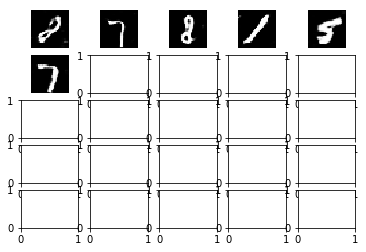

In [7]:
X_train = load_data()
batch_size = 128
epochs = 400

num_examples = X_train.shape[0]
num_batches = int(num_examples / float(batch_size))
half_batch = int(batch_size / 2)


for epoch in range(epochs + 1):
    for batch in range(num_batches):
    # noise images for the batch
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))
        # real images for batch
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_images = X_train[idx]
        real_labels = np.ones((half_batch, 1))
        # Train the discriminator (real classified as ones and generated as zeros)

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        noise = np.random.normal(0, 1, (batch_size, 100))
        # Train the generator
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
        # Plot the progress
        if batch % 50 == 0:
            save_imgs(generator, epoch, batch)
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

                # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        if batch % 50 == 0:
            save_imgs(generator, epoch, batch)

